In [1]:
!pip install split-folders


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import tensorflow as tf
import os
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [3]:
DATA_DIR = 'asl_dataset'
OUTPUT_DIR = 'asl_split_dataset' 

splitfolders.ratio(DATA_DIR, output=OUTPUT_DIR, seed=42, ratio=(0.64, 0.16, 0.2))

Copying files: 2515 files [00:10, 230.04 files/s]


In [4]:
SAMPLE_IMAGE = 'asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg'

IMAGE_SIZE = (224, 224, 3)  
BATCH_SIZE = 32
EPOCHS = 40
LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.2

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

In [5]:
num_classes = 36

In [6]:
BEST_MODEL_PATH = 'best_model.h5'
FINAL_MODEL_PATH = 'final_model.h5'

In [7]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/train',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/val',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'asl_split_dataset/test',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    color_mode='rgb'
)

Found 1581 files belonging to 36 classes.
Found 395 files belonging to 36 classes.
Found 539 files belonging to 36 classes.


In [10]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
#     tf.keras.layers.RandomBrightness(0.1),
#     tf.keras.layers.RandomTranslation(0.2, 0.2),
# ])

In [9]:
train_dataset = train_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
val_dataset = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [11]:
# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)).cache().shuffle(1000).prefetch(PREFETCH_BUFFER_SIZE)
# val_dataset = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)
# test_dataset = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [14]:
from tensorflow.keras import utils as np_utils
base_model = tf.keras.applications.mobilenet.MobileNet()
base_model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [15]:
base_model = MobileNet(input_shape=IMAGE_SIZE, include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,772,132 (14.39 MB)

 Trainable params: 543,268 (2.07 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=15,            
    restore_best_weights=True  
)

In [18]:
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,  
    callbacks=[early_stopping]  
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.1860 - loss: 8.6474 - val_accuracy: 0.5291 - val_loss: 1.2784
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.6049 - loss: 1.1377 - val_accuracy: 0.7316 - val_loss: 0.7117
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.7112 - loss: 0.7838 - val_accuracy: 0.7797 - val_loss: 0.5680
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.7757 - loss: 0.6279 - val_accuracy: 0.8203 - val_loss: 0.5045
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.8088 - loss: 0.5120 - val_accuracy: 0.8203 - val_loss: 0.4578
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.7885 - loss: 0.5836 - val_accuracy: 0.7772 - val_loss: 0.5376
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.7936 - loss: 0.5438 - val_accuracy: 0.8557 - val_loss: 0.3656
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.8059 - loss: 0.4993 - 

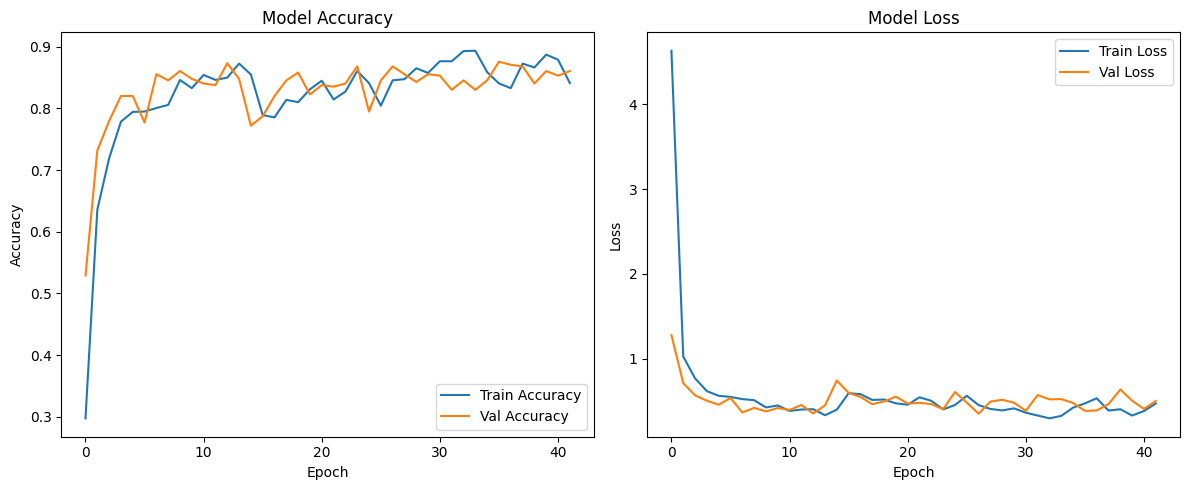

In [19]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial)

In [20]:
for layer in base_model.layers[-20:]:  
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=250,
    initial_epoch=history_initial.epoch[-1],  
    callbacks=[early_stopping]  
)

Epoch 42/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.3745 - loss: 9.0213 - val_accuracy: 0.8886 - val_loss: 0.3247
Epoch 43/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.4912 - loss: 4.9041 - val_accuracy: 0.8582 - val_loss: 0.4285
Epoch 44/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.5799 - loss: 3.2548 - val_accuracy: 0.8329 - val_loss: 0.6133
Epoch 45/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.6852 - loss: 1.9395 - val_accuracy: 0.8380 - val_loss: 0.7685
Epoch 46/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.7020 - loss: 1.7992 - val_accuracy: 0.8304 - val_loss: 0.9050
Epoch 47/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.7433 - loss: 1.4749 - val_accuracy: 0.8354 - val_loss: 0.9226
Epoch 48/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.7874 - loss: 1.0672 - val_accuracy: 0.8329 - val_loss: 0.8818
Epoch 49/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.7819 - loss: 1

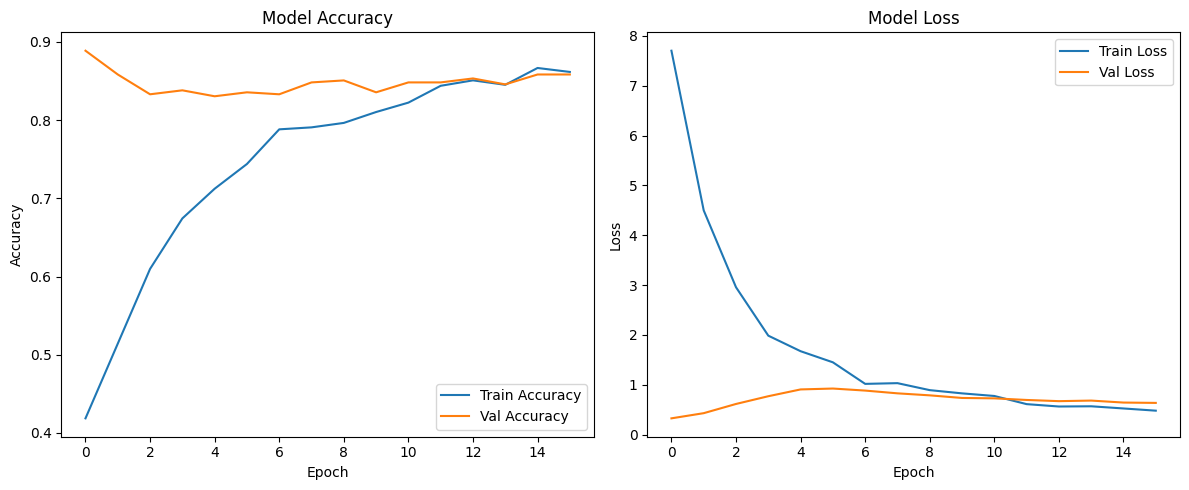

In [22]:
plot_training_history(history_fine_tune)

In [24]:
model.save('fine_tuned_model.h5')

In [26]:
model.save('fine_tuned_model.keras')

In [23]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.9367 - loss: 0.1695
Test Accuracy: 92.39%
Test Loss: 0.1986
